# Importing Libraries

In [ ]:
%pip install matplotlib, pandas, keras, tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import os

from keras.utils import image_dataset_from_directory, load_img, img_to_array
# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D,Rescaling
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

# Displaying Images

In [2]:
picture_size = 48
folder_path = "../Ht23-Deep-Learning-Tentamen/images/"

In [3]:
os.listdir(folder_path+"train")

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

disgust


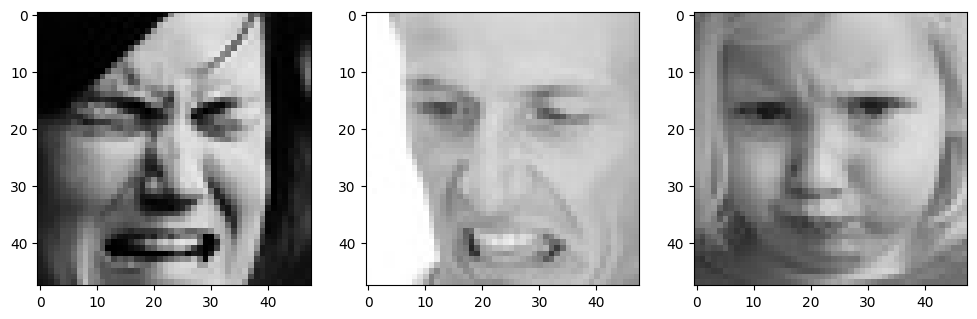

happy


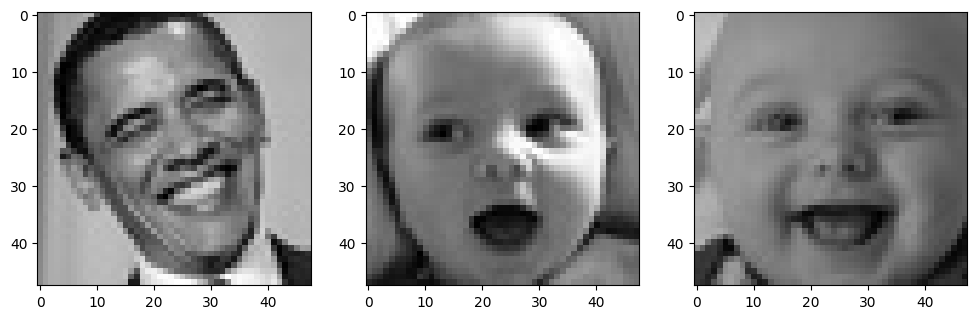

surprise


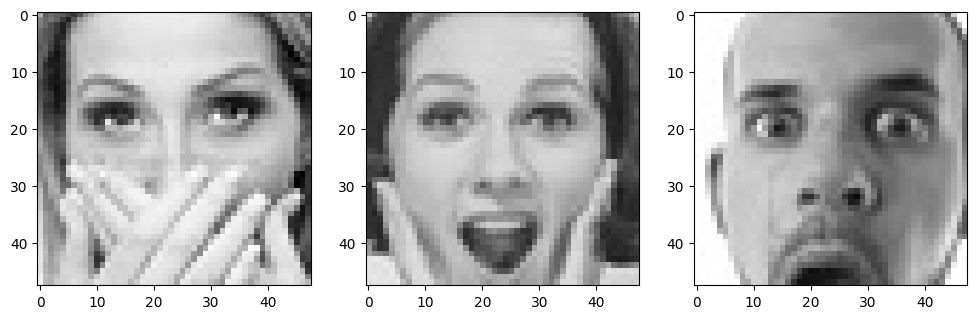

In [4]:
expression = ['disgust', 'happy', 'surprise']

for exp in expression:
    plt.figure(figsize= (12,12))
    print(exp)
    for i in range(1, 4, 1):
        plt.subplot(1,3,i)
        img = load_img(folder_path+"train/"+exp+"/"+
                       os.listdir(folder_path + "train/" + exp)[i], target_size=(picture_size, picture_size))
        plt.imshow(img)
    plt.show()

# Making Training and Validation Data

In [ ]:
# batch_size  = 128

# datagen_train  = ImageDataGenerator()
# datagen_val = ImageDataGenerator()

# train_set = datagen_train.flow_from_directory(folder_path+"train",
#                                               target_size = (picture_size,picture_size),
#                                               color_mode = "grayscale",
#                                               batch_size=batch_size,
#                                               class_mode='categorical',
#                                               shuffle=True)


# test_set = datagen_val.flow_from_directory(folder_path+"validation",
#                                               target_size = (picture_size,picture_size),
#                                               color_mode = "grayscale",
#                                               batch_size=batch_size,
#                                               class_mode='categorical',
#                                               shuffle=False)

In [8]:
batch_size  = 32

# tf.keras.utils.image_dataset_from_directory
train_ds = image_dataset_from_directory(
    folder_path+"train",
    labels="inferred",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    folder_path+"validation",
    labels="inferred",
    # validation_split needed for validation dataset?
    # validation_split=0.2,
    # subset="validation",
    seed=42,
    image_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    # Test with shuffle too
    shuffle=False
)

train_ds = train_ds.take(100)
val_ds = val_ds.take(100)


Found 28823 files belonging to 7 classes.
Using 23059 files for training.
Found 7066 files belonging to 7 classes.


In [11]:
# Normalization layer
# TODO: Print arrayed floats, add Rescaling layer to model instead
normalization_layer = Rescaling(1./255)

# Model Building

In [12]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

# Fitting the Model with Training and Validation Data 

In [13]:
# from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 3

model.compile(loss='SparseCategoricalCrossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [14]:
# steps_per_epoch and validation_steps commented out due to default values
# "WARNING:tensorflow:Can save best model only with val_acc available, skipping."

history = model.fit(train_ds, 
                                # steps_per_epoch=train_ds.n//train_ds.batch_size,
                                epochs=epochs,
                                validation_data = val_ds,
                                # validation_steps = val_ds.n//val_ds.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/3


100/100 [==============================] - ETA: 0s - loss: 2.0357 - accuracy: 0.2313WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 47s 441ms/step - loss: 2.0357 - accuracy: 0.2313 - val_loss: 2.1541 - val_accuracy: 0.2681 - lr: 0.0010
Epoch 2/3
100/100 [==============================] - ETA: 0s - loss: 1.8560 - accuracy: 0.2847WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 44s 443ms/step - loss: 1.8560 - accuracy: 0.2847 - val_loss: 1.7388 - val_accuracy: 0.3569 - lr: 0.0010
Epoch 3/3
100/100 [==============================] - ETA: 0s - loss: 1.7204 - accuracy: 0.3388WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - 45s 446ms/step - loss: 1.7204 - accuracy: 0.3388 - val_loss: 1.8207 - val_accuracy: 0.3678 - lr: 0.0010


# Plotting Accuracy & Loss

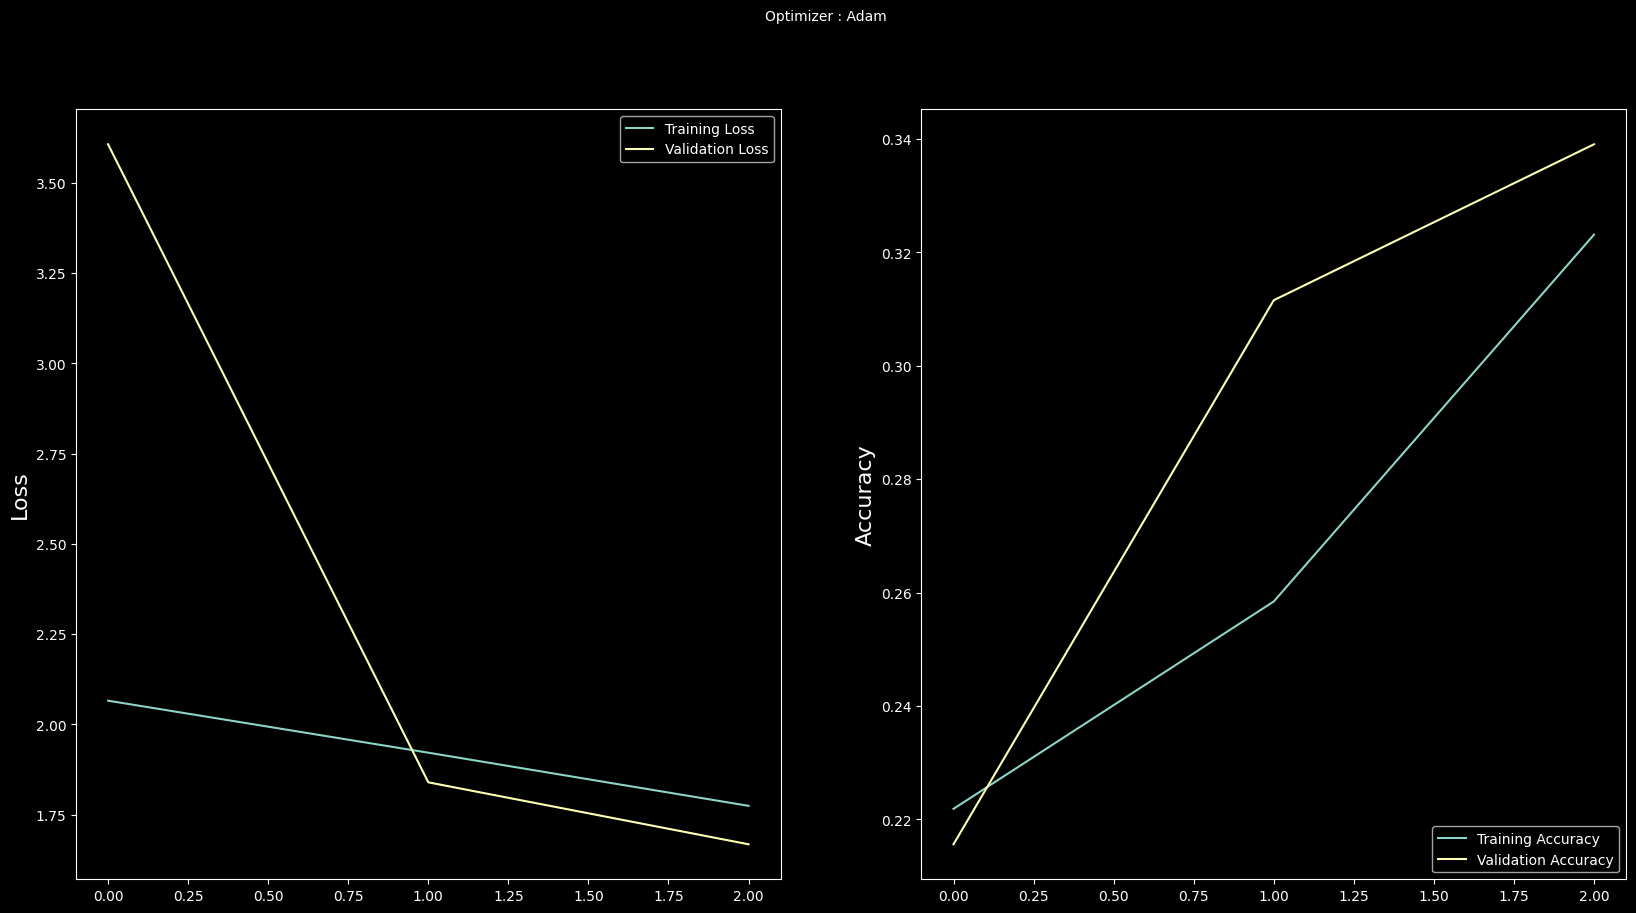

In [10]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()